In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = 50000
from xshooter_synthmag import Filter, synthcolor

/datascope/slurm/miniconda3/envs/astro-dnn/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/datascope/slurm/miniconda3/envs/astro-dnn/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Loading in x-shooter data

In [2]:
DATA_DIR = '/datascope/subaru/data/catalogs/xshooter/fits/'
#directory of where xshooter files are

#I've picked out a few stars from X-shooter to look at, here I list their names
# and properties
files_list = ['xsl_spectrum_X0422_merged.fits', #relatively metal-rich k-giant star ([Fe/H] ~ 0.2)
             'xsl_spectrum_X0363_merged.fits', #metal-poor k-giant star ([Fe/H] ~ -2.4)
            'xsl_spectrum_X0511_merged.fits', #AGB star ([Fe/H] ~ -0.4)
            'xsl_spectrum_X0044_merged.fits', #M-giant ([Fe/H] ~ -0.1)
            'xsl_spectrum_X0418_merged.fits', #metal-poor, 'chemically peculiar' g-giant ([Fe/H] ~ -2.3)
            'xsl_spectrum_X0162_merged.fits', #metal-rich, g-giant ([Fe/H] ~0.1)
            'xsl_spectrum_X0782_merged.fits', #metal-poor rr lyrae ([Fe/H] ~ -1.7)
            'xsl_spectrum_X0639_merged.fits', #metal-poor BHB ([Fe/H] ~ -1.3)
            'xsl_spectrum_X0390_merged.fits', #k-dwarf ([Fe/H] ~ -0.3)
            'xsl_spectrum_X0831_merged.fits', #f-dwarf ([Fe/H] ~ -0.3)
            'xsl_spectrum_X0382_merged.fits'] #g-dwarf ([Fe/H] ~ -0.4)
name_list = ['metal-rich k-giant',
            'metal-poor k-giant',
            'AGB',
            'm-giant',
            'metal-poor g-giant',
             'metal-rich g-giant',
            'metal-poor RR lyrae',
             'metal-poor BHB',
             'k-dwarf',
            'f-dwarf',
            'g-dwarf']

In [3]:
#lets see what data is in one of the x-shooter files
hdus = fits.open(DATA_DIR+'xsl_spectrum_X0422_merged.fits', memmap=False)
hdus[0].header #hdus[1].header
#from the header, we know that this star is named HD 4893. we can look this star
# up by its name in vizier or simbad
#and get information about its temperature and log(g) 

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OBJECT  = 'HD004893'           / Machine-readable name of the star              
HNAME   = 'HD 4893 '           / Human-readable name of the star                
XSL_ID  = 'X0422   '           / X-shooter Spectral Library unique identifier   
RA      =    12.34408333333333 / [deg] Spectroscopic target position (J2000)    
DEC     =   -73.47866111111111 / [deg] Spectroscopic target position (J2000)    
RA_FULL = '00:49:22.58'        / [HH:MM:SS.SS] Target position (J2000)          
DEC_FULL= '-73:28:43.18'       / [DD:MM:SS.SS] Target position (J2000)          
EQUINOX =               2000.0 / Standard FK5                                   
RADECSYS= 'FK5     '        

In [4]:
hdus[1].data #the data has wavelength, flux, deredened flux, and error in flux 
#we will want to use the de-reddened flux, i.e. flux_dr

FITS_rec([( 350.     , 1.2775197e-15, 1.2775197e-15, 1.2173860e-13),
          ( 350.0117 , 1.1601396e-13, 1.1601396e-13, 1.2188833e-13),
          ( 350.02335, 9.1615693e-15, 9.1615693e-15, 1.2084570e-13), ...,
          (2476.794  , 1.4761918e-13, 1.4761918e-13, 3.4227975e-15),
          (2476.8765 , 1.3909123e-13, 1.3909123e-13, 3.3573589e-15),
          (2476.959  , 1.3779878e-13, 1.3779878e-13, 3.3491734e-15)],
         dtype=(numpy.record, [('WAVE', '>f4'), ('FLUX', '>f4'), ('FLUX_DR', '>f4'), ('ERR', '>f4')]))

In [5]:
#lets get the table that has all of the stellar atmospheric parameters, we can
#then match the catalogue to our stars and find the log(g), [Fe/H] info for 
#each star
#table is here: https://vizier.cds.unistra.fr/viz-bin/VizieR searching for catalog
# named J/A+A/627/A138/tablea1
table = Vizier.get_catalogs('J/A+A/627/A138/tablea1')
stellar_params = table[0].to_pandas()
stellar_params.columns #lets see what info we have

Index(['HNAME', 'x', 'Teffuvb', 'logguvb', '__Fe_H_uvb', 'Teffvis', 'loggvis',
       '__Fe_H_vis', 'Teff', 'e_Teff', 'logg', 'e_logg', '__Fe_H_', 'e__Fe_H_',
       'f_Teff', 'f_logg', 'f__Fe_H_', 'Cflag', 'SimbadName', '_RA', '_DE'],
      dtype='object')

In [36]:
#now we can find which entry in the stellar params table matches our stars name
#we'll do this by using .str.contains (to see if stellar param HNAME contains header HNAME, 
# allowing for their to be weird extra spaces etc) or stellar param HNAME == hdu HNAME to check
# for if the HNAMEs are exactly equal!
#note that not /all/ of the stars in x-shooter have a match in this data
stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_']

176   -0.42
Name: __Fe_H_, dtype: float32

# lets make some synthetic colors!

In [7]:
#loading in our filters
filt_g = Filter()
filt_g.read('/datascope/subaru/data/pfsspec/subaru/hsc/filters/fHSC-g.txt')

filt_i = Filter()
filt_i.read('/datascope/subaru/data/pfsspec/subaru/hsc/filters/fHSC-i.txt')


filt_nb515 = Filter()
filt_nb515.read('/datascope/subaru/data/pfsspec/subaru/hsc/filters/fHSC-NB515.txt')


In [8]:
#synthcolor takes your xshooter data (here hdus[1]), two filters, and deredening
#argument. Here, we want to use dered = True. Synthcolor will return
# the color filter_1 - filter_2
g_i = synthcolor(hdus[1], filt_g, filt_i, dered=True)
nb_g = synthcolor(hdus[1], filt_nb515, filt_g, dered=True)

Warning, 268 of 58666 bins contained negative fluxes; they have been set to zero.
Warning, 268 of 58666 bins contained negative fluxes; they have been set to zero.


In [37]:
print('star ', 
    hdus[0].header['HNAME'],
    ' has [Fe/H] of ',
    stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_'].values[0],
    ' and log(g) of',
    stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['logg'].values[0],
    ' and g-i color of ', g_i, ' and NB515 - g color of ',
    nb_g)

star  HD 126053  has [Fe/H] of  -0.42  and log(g) of 4.24  and g-i color of  0.5459888784479663  and NB515 - g color of  -0.09775132059381342


In [34]:
#lets do compute colors for all of the stars that we found above, and see where they 
# are on the color-color plots
fehs = np.array([])
teffs = np.array([])
loggs = np.array([])
g_i_color = np.array([])
nb_g_color = np.array([])


for i in range(len(files_list)):
    fn = os.path.join(DATA_DIR, files_list[i])
    hdus = fits.open(fn, memmap=False)
    print('looking at ', name_list[i])
    #get all the stellar param info
    logg = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])].logg.mean()
    loggs = np.append(loggs, logg)
    teff = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])].Teff.mean()
    teffs = np.append(teffs, teff)
    feh = stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]['__Fe_H_'].mean()
    fehs = np.append(fehs, feh)
    #synth_g = synthmagnoR(hdus[1], filt_g, dered=False)
    #synth_i = synthmagnoR(hdus[1], filt_i, dered=False)
    #synth_nb = synthmagnoR(hdus[1], filt_nb515, dered=False)

    g_i = synthcolor(hdus[1], filt_g, filt_i, dered=True)
    nb_g = synthcolor(hdus[1], filt_nb515, filt_g, dered=True)
    g_i_color = np.append(g_i_color, g_i)
    nb_g_color = np.append(nb_g_color, nb_g)
    


looking at  metal-rich k-giant
Warning, 268 of 58666 bins contained negative fluxes; they have been set to zero.
Warning, 268 of 58666 bins contained negative fluxes; they have been set to zero.
looking at  metal-poor k-giant
Warning, 193 of 58666 bins contained negative fluxes; they have been set to zero.
Warning, 193 of 58666 bins contained negative fluxes; they have been set to zero.
looking at  AGB
Warning, 1938 of 58666 bins contained negative fluxes; they have been set to zero.
Warning, 1938 of 58666 bins contained negative fluxes; they have been set to zero.
looking at  m-giant
Warning, 1248 of 58663 bins contained negative fluxes; they have been set to zero.
Warning, 1248 of 58663 bins contained negative fluxes; they have been set to zero.
looking at  metal-poor g-giant
Warning, 83 of 58666 bins contained negative fluxes; they have been set to zero.
Warning, 83 of 58666 bins contained negative fluxes; they have been set to zero.
looking at  metal-rich g-giant
Warning, 295 of 58

In [47]:
fn = os.path.join(DATA_DIR, files_list[1])
hdus = fits.open(fn, memmap=False)
stellar_params[stellar_params['HNAME'].str.contains(hdus[0].header['HNAME'])]#.Teff

stellar_params[(stellar_params['HNAME'].str.contains(hdus[0].header['HNAME']))
            |(stellar_params['HNAME']==hdus[0].header['HNAME'])]
#hdus[0].header['HNAME'][-4:]
stellar_params[stellar_params['HNAME'].str.contains(hdus[0].header['HNAME'], regex=False)],stellar_params.iloc[28]['HNAME'] == hdus[0].header['HNAME']


(         HNAME    x  Teffuvb  logguvb  __Fe_H_uvb  Teffvis  loggvis  \
 28  BD+09 2870  363     4664     1.47       -2.34     4643     1.49   
 
     __Fe_H_vis  Teff  e_Teff  ...  e_logg  __Fe_H_  e__Fe_H_  f_Teff  f_logg  \
 28       -2.37  4664      51  ...    0.15    -2.34      0.07    <NA>    <NA>   
 
     f__Fe_H_  Cflag  SimbadName        _RA      _DE  
 28      <NA>   <NA>  BD+09 2870  214.12479  8.46472  
 
 [1 rows x 21 columns],
 True)

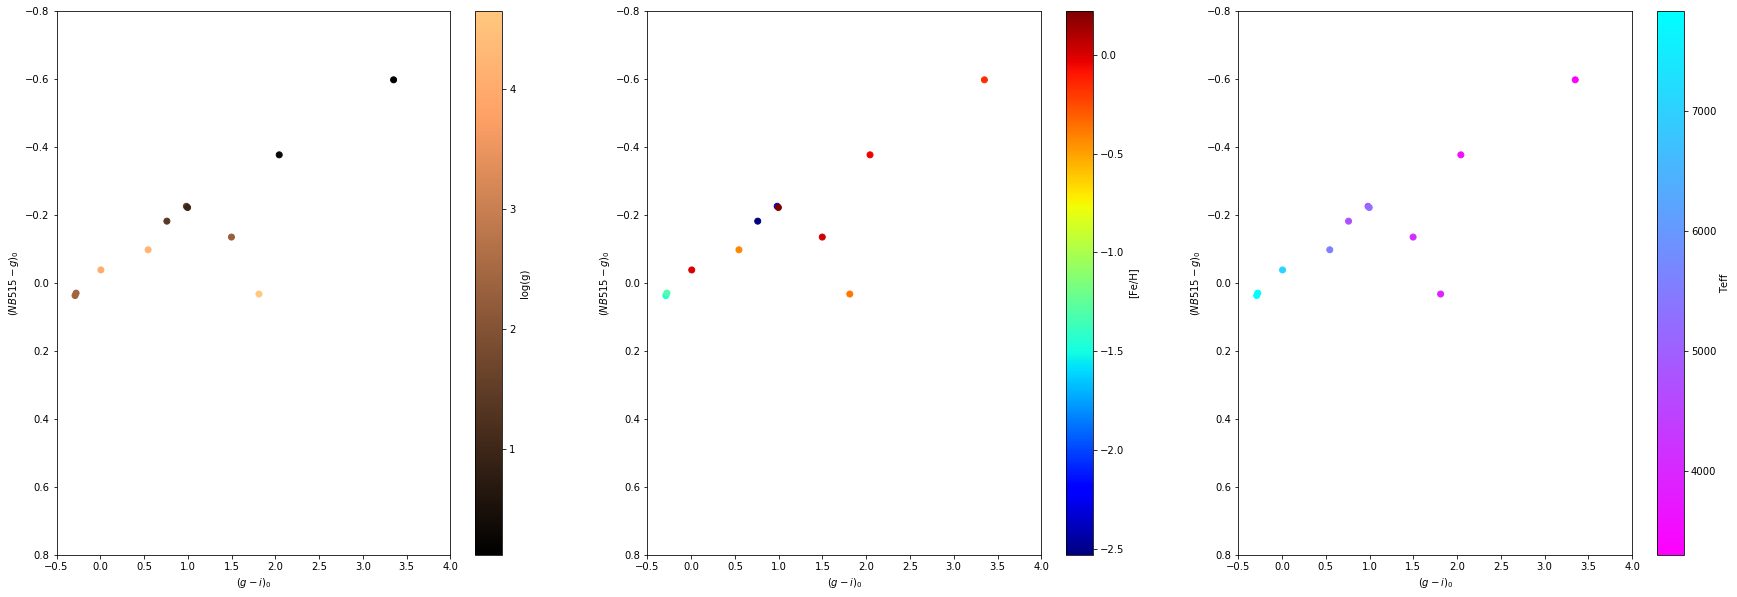

In [35]:
#plotting, color-coded by logg, metallicity, temp
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,10))
c1 = ax1.scatter(g_i_color, nb_g_color, c=loggs,cmap='copper')
ax1.set_xlim(-0.5, 4)
ax1.set_ylim(0.8,-0.8)
ax1.set_xlabel('$(g-i)_0$')
ax1.set_ylabel('$(NB515 - g)_0$')

c2 = ax2.scatter(g_i_color, nb_g_color, c=fehs,cmap='jet')
ax2.set_xlim(-0.5, 4)
ax2.set_ylim(0.8,-0.8)
ax2.set_xlabel('$(g-i)_0$')
ax2.set_ylabel('$(NB515 - g)_0$')

c3 = ax3.scatter(g_i_color, nb_g_color, c=teffs,cmap='cool_r')
ax3.set_xlim(-0.5, 4)
ax3.set_ylim(0.8,-0.8)
ax3.set_xlabel('$(g-i)_0$')
ax3.set_ylabel('$(NB515 - g)_0$')

fig.colorbar(c1, ax=ax1, orientation = 'vertical', label='log(g)')
fig.colorbar(c2, ax=ax2, orientation = 'vertical', label='[Fe/H]')
fig.colorbar(c3, ax=ax3, orientation = 'vertical', label='Teff')

## Next, lets look at /all/ of the stars with x-shooter spectra. We should look up the stars in Simbad that do NOT have stellar parameter information in the table from Vizier (we can look them up by their HNAME - they should all be on Simbad!) and we should also identify the stars with multiple entries. We should make a separate file with the stars without stellar parameter estimates, and add in parameter info as we find it (we should also note if they are 'weird' stars, like mira variables!). We can use the stars with multiple entries to better understand the precision and errors of our synthetic colors - it would be useful to know what kind of star each star with duplicate entries is, too!

### ( we can search for each of the stars on simbad, following this link http://simbad.u-strasbg.fr/simbad/ and putting the HNAME from the data file header into the 'basic search' bar)